In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import corner.corner
from emcee.autocorr import integrated_time
from impulse.base import Sampler, PTSampler

# test model things:
from test_model import make_sin_data, LnLikelihood, LnPrior

In [2]:
x, data, omega_real, a_real, phi_real = make_sin_data(1000)

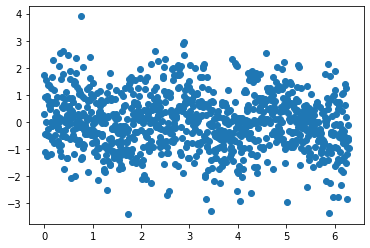

In [3]:
plt.scatter(x, data)

In [4]:
like = LnLikelihood(x, data)
prior = LnPrior([0, 0, 0], [3, 5, np.pi])

In [5]:
x0 = prior.initial_sample()
ndim = len(x0)

In [6]:
ntemps = 1
ncores = 1
sampler = Sampler(ndim, like, prior, ntemps=ntemps, ncores=ncores, adapt=False, tinf=False)
# sampler = PTSampler(ndim, like, prior)

In [7]:
x0 = np.vstack([prior.initial_sample() for i in range(ntemps)])
chain = sampler.sample(x0, num_samples=100_000, ret_chain=True)

100%|██████████| 1000/1000 [00:13<00:00, 74.17it/s]


In [8]:
burn = int(0.25 * chain[0].shape[0])
omega = np.median(chain[0][burn:, 0])
a = np.median(chain[0][burn:, 1])
phi = np.median(chain[0][burn:, 2])

In [9]:
print(omega, omega_real)
print(a, a_real)
print(phi, phi_real)

2.8462308676307675 2.8934334882850976
0.3871408025171925 0.3901935991060379
0.33458011072854354 0.22377546139751905


In [10]:
with open('./chains/temp_data/temps.txt', 'r') as f:
    temps = np.loadtxt(f)

with open('./chains/temp_data/accept.txt', 'r') as f:
    accept = np.loadtxt(f)

/var/folders/bt/hxhr8xxx7d11f4lwfyj1_b580000gn/T/ipykernel_57577/3406890032.py:2: UserWarning: loadtxt: Empty input file: "<_io.TextIOWrapper name='./chains/temp_data/temps.txt' mode='r' encoding='UTF-8'>"
  temps = np.loadtxt(f)
/var/folders/bt/hxhr8xxx7d11f4lwfyj1_b580000gn/T/ipykernel_57577/3406890032.py:5: UserWarning: loadtxt: Empty input file: "<_io.TextIOWrapper name='./chains/temp_data/accept.txt' mode='r' encoding='UTF-8'>"
  accept = np.loadtxt(f)


In [11]:
plt.figure(figsize=(12, 5))
for ii in range(ntemps - 1):
    # plt.plot(temps[:, ii])
    plt.plot(accept[:, ii])
plt.show()

plt.figure(figsize=(12, 5))
for ii in range(ntemps - 1):
    plt.plot(temps[:, ii])
    # plt.plot(accept[:, ii])
plt.show()

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

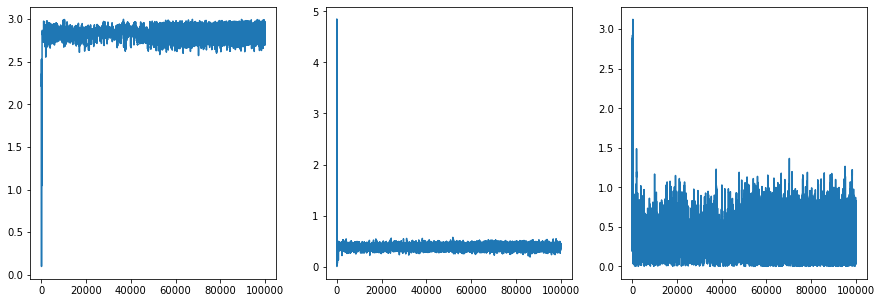

In [12]:
for ii in range(ntemps):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].plot(chain[ii, :, 0])
    ax[1].plot(chain[ii, :, 1])
    ax[2].plot(chain[ii, :, 2])
    plt.show()

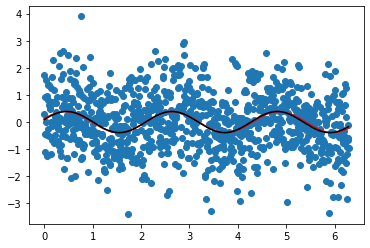

In [13]:
plt.scatter(x, data)
plt.plot(x, a * np.sin(omega * x + phi), color='red')
plt.plot(x, a_real * np.sin(omega_real * x + phi_real), color='black')

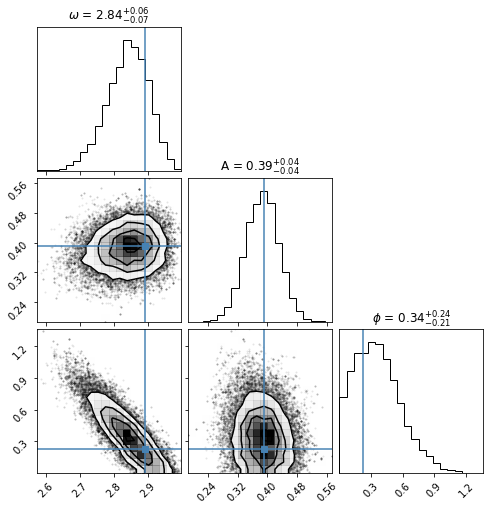

In [14]:
corner.corner(chain[0, 2 * burn:, :], truths=[omega_real, a_real, phi_real],
              titles=[r'$\omega$', r'A', r'$\phi$'], show_titles=True)
plt.show()

In [15]:
print(omega_real, a_real, phi_real)
print(omega, a, phi)

2.8934334882850976 0.3901935991060379 0.22377546139751905
2.8462308676307675 0.3871408025171925 0.33458011072854354


In [18]:
print(integrated_time(chain[0, :, 0]))

[185.58746782]
